---

CARGA DE LIBRERÍA Y DATOS

---

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, classification_report
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy.stats import chi2
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer
from sklearn.preprocessing import FunctionTransformer, RobustScaler
from sklearn.metrics import mean_squared_error

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Cupido_IA_project/train.csv')
test = pd.read_csv("/content/drive/MyDrive/Cupido_IA_project/test.csv")
submission = pd.read_csv("/content/drive/MyDrive/Cupido_IA_project/sample_submission.csv")

---

## DEFINICIÓN PREPROCESADO

---

In [ ]:
cols_to_int = ['age', 'sex', 'cp', 'restecg']

rename_dict = {
    "age": "edad",
    "sex": "sexo",
    "cp": "tipo_dolor_pecho",
    "trestbps": "tension_en_descanso",
    "chol": "colesterol",
    "fbs": "azucar",
    "restecg": "electro_en_descanso",
    "thalach": "latidos_por_minuto",
    "exang": "dolor_pecho_con_ejercicio",
    "oldpeak": "cambio_linea_corazon_ejercicio",
    "slope": "forma_linea_corazon_ejercicio",
    "ca": "num_venas_grandes",
    "thal": "estado_corazon_thal" }

cols_a_clippear = [
    'tension_en_descanso', 'colesterol',
    'latidos_por_minuto', 'cambio_linea_corazon_ejercicio']

categorical_cols_to_round = [
    'num_venas_grandes', 'estado_corazon_thal', 'sexo',
    'tipo_dolor_pecho', 'dolor_pecho_con_ejercicio',
    'azucar', 'forma_linea_corazon_ejercicio', 'electro_en_descanso']

---

FUNCIONES DE PREPROCESADO

---

In [ ]:
def limpieza_inicial(df):
    """
    Realiza conversiones de tipos, renombres y limpieza básica de errores (-9).
    Se puede aplicar a todo el dataset antes del split.
    """
    df = df.copy()

    # Conversión a Int
    for col in cols_to_int:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce').astype('Int64')

    # Conversión de objetos a numérico
    object_cols = df.select_dtypes(include=['object']).columns
    for col in object_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    # Renombrar
    df = df.rename(columns=rename_dict)

    # Reemplazar errores conocidos (-9) por NaN
    df.replace([-9, -9.0], np.nan, inplace=True)

    return df

In [ ]:
def limpiar_ceros_fisiologicos(X):
    X = X.copy()
    cols_imposibles_con_cero = ['tension_en_descanso', 'colesterol']
    for col in cols_imposibles_con_cero:
        if col in X.columns:
            X[col] = X[col].replace({0: np.nan, 0.0: np.nan})
    return X

In [ ]:
def clipear_outliers(X):
    """
    Nota: Usado en FunctionTransformer, esto calculará los cuantiles
    sobre el lote actual de datos.
    """
    X = X.copy()
    for col in cols_a_clippear:
        if col in X.columns:
            p1 = X[col].quantile(0.01)
            p99 = X[col].quantile(0.99)
            X[col] = X[col].clip(lower=p1, upper=p99)
    return X

In [ ]:
def crear_flags_mnar(df):
    df_new = df.copy()
    cols_mnar = ['num_venas_grandes', 'estado_corazon_thal']
    for col in cols_mnar:
        if col in df_new.columns:
            df_new[f'{col}_is_missing'] = df_new[col].isna().astype(int)
    return df_new

In [ ]:
def redondear_imputaciones(X):
    X = X.copy()
    for col in categorical_cols_to_round:
        if col in X.columns:
            X[col] = X[col].round()
    return X

In [ ]:
def optimizar_k_knn(X_train, k_range=[3, 5, 7, 9, 11, 15]):
    # Preparamos una copia limpia para testear
    X_temp = limpiar_ceros_fisiologicos(X_train)
    X_temp = clipear_outliers(X_temp)
    # Solo usamos filas completas para validar el error de imputación
    X_complete = X_temp.dropna().copy()

    if len(X_complete) < 50:
        print("Pocos datos completos. Se usará k=5 por defecto.")
        return 5

    rmse_scores = {}
    scaler = RobustScaler()
    X_scaled_array = scaler.fit_transform(X_complete)

    np.random.seed(42)
    mask = np.random.rand(*X_scaled_array.shape) < 0.1
    X_missing_sim = X_scaled_array.copy()
    X_missing_sim[mask] = np.nan

    print(f"Buscando k óptimo sobre {len(X_complete)} muestras...")
    for k in k_range:
        imputer = KNNImputer(n_neighbors=k, weights='distance')
        X_imputed = imputer.fit_transform(X_missing_sim)
        error = np.sqrt(mean_squared_error(X_scaled_array[mask], X_imputed[mask]))
        rmse_scores[k] = error

    best_k = min(rmse_scores, key=rmse_scores.get)
    print(f"Mejor k encontrado: {best_k}")
    return best_k

---
## APLICACIÓN DEL FLUJO DE PREPROCESADO DEFINIDO

---

In [ ]:
df_train = df.copy()
df_test = test.copy()

df_train = limpieza_inicial(df_train)
df_test = limpieza_inicial(df_test)

target = "label"

X_train = df_train.drop(columns=target)
y_train = df_train[target]

if target in df_test.columns:
    X_test = df_test.drop(columns=target)
    y_test = df_test[target]
else:
    X_test = df_test.copy()

best_k = optimizar_k_knn(X_train)

pipeline_imputacion = Pipeline([
    ('limpieza_ceros', FunctionTransformer(limpiar_ceros_fisiologicos, validate=False)),
    ('clipear_outliers', FunctionTransformer(clipear_outliers, validate=False)),
    ('mnar_flags', FunctionTransformer(crear_flags_mnar, validate=False)),
    ('scaler', RobustScaler()), # Aprende la mediana y rango intercuartílico de TRAIN
    ('knn_imputer', KNNImputer(n_neighbors=best_k, weights='distance')), # Aprende vecinos de TRAIN
    ('rounding', FunctionTransformer(redondear_imputaciones, validate=False))
]).set_output(transform="pandas")

Buscando k óptimo sobre 246 muestras...
Mejor k encontrado: 15


---
## EJECUCIÓN Y VERIFICACIÓN DE TRANSFORMACIÓN

---

In [ ]:
print("Ajustando pipeline con TRAIN completo...")
X_train_prep = pipeline_imputacion.fit_transform(X_train)

print("Aplicando preprocesamiento a TEST...")
X_test_prep = pipeline_imputacion.transform(X_test)

print("\n--- Proceso finalizado ---")
print(f"Dimensiones Train procesado: {X_train_prep.shape}")
print(f"Dimensiones Test procesado : {X_test_prep.shape}")

print(f"Nulos restantes en Train: {X_train_prep.isna().sum().sum()}")
print(f"Nulos restantes en Test : {X_test_prep.isna().sum().sum()}")

Ajustando pipeline con TRAIN completo...
Aplicando preprocesamiento a TEST...

--- Proceso finalizado ---
Dimensiones Train procesado: (732, 15)
Dimensiones Test procesado : (184, 15)
Nulos restantes en Train: 0
Nulos restantes en Test : 0


---

## ANÁLISIS LOWESS PARA COMPROBAR LA NO LINEALIDAD

---

In [ ]:
df_viz = X_train_prep.copy()
df_viz['label'] = y_train.values

# Crear Target Binario (Sano vs Enfermo)
# Esto ayuda al LOWESS a dibujar una curva de "Probabilidad de Enfermedad"
df_viz['target_binario'] = df_viz['label'].apply(lambda x: 1 if x > 0 else 0)

# Definir las variables continuas que queremos analizar
# Excluimos las categóricas redondeadas y los flags de nulos (_is_missing)
cols_continuas_analisis = [
    "edad",
    "tension_en_descanso",
    "colesterol",
    "latidos_por_minuto",
    "cambio_linea_corazon_ejercicio"]

# Filtramos solo las que existen en el dataframe procesado
cols_to_plot = [col for col in cols_continuas_analisis if col in df_viz.columns]

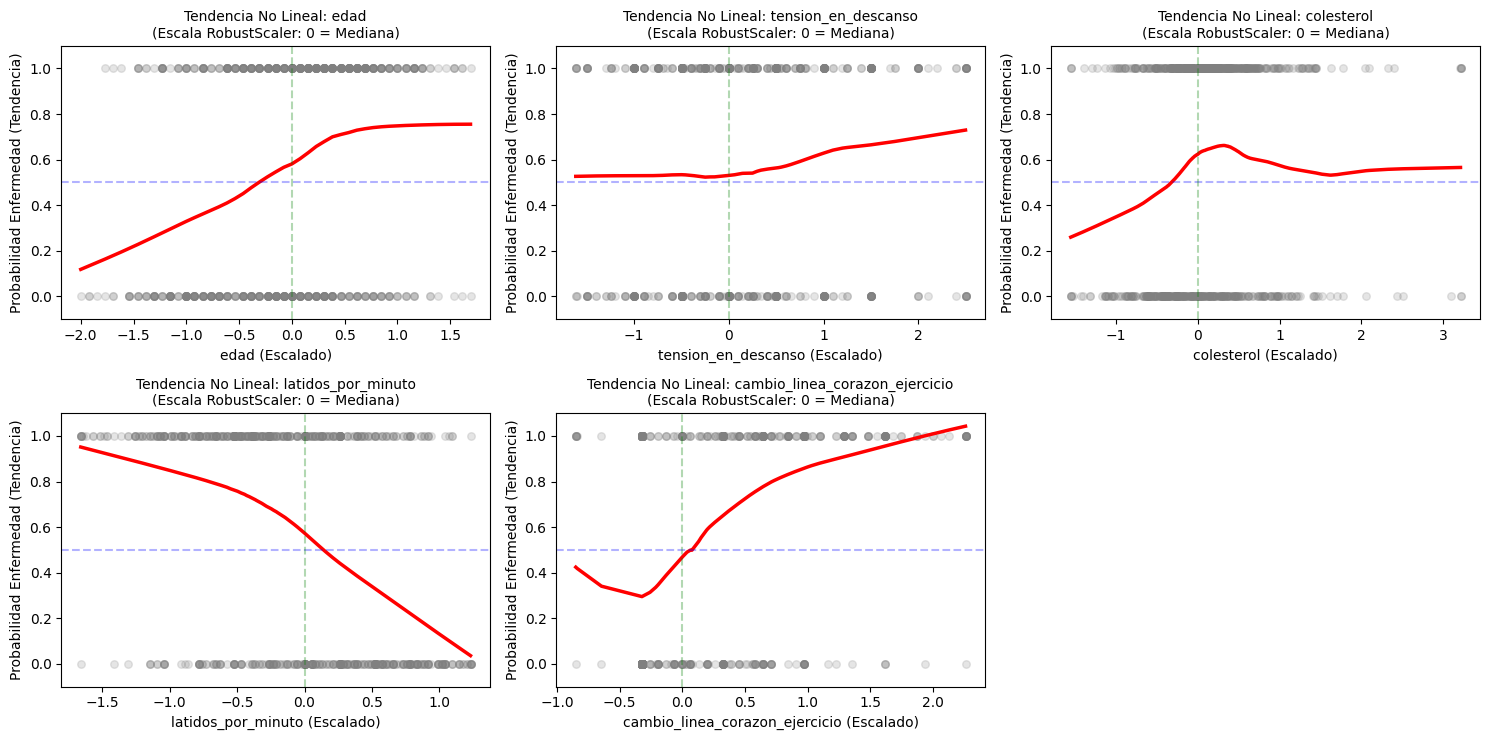

In [ ]:
# Generación de Gráficos
plt.figure(figsize=(15, 7.5))

for i, col in enumerate(cols_to_plot):
    plt.subplot(2, 3, i+1)

    # Scatter plot: Puntos reales (con transparencia para ver densidad)
    # Regplot: Dibuja la línea LOWESS
    sns.regplot(
        x=col,
        y='target_binario',
        data=df_viz,
        logistic=False, # False para permitir libertad a la línea (no forzar sigmoide)
        lowess=True,    # ACTIVAMOS LOWESS
        scatter_kws={'alpha': 0.2, 'color': 'gray', 's': 30}, # Puntos grises de fondo
        line_kws={'color': 'red', 'linewidth': 2.5} # Línea de tendencia roja
    )

    plt.title(f"Tendencia No Lineal: {col}\n(Escala RobustScaler: 0 = Mediana)", fontsize=10)
    plt.ylabel("Probabilidad Enfermedad (Tendencia)")
    plt.xlabel(f"{col} (Escalado)")

    # Línea guía en probabilidad 0.5
    plt.axhline(0.5, color='blue', linestyle='--', alpha=0.3)
    # Línea guía en mediana de la variable (0 debido al RobustScaler)
    plt.axvline(0, color='green', linestyle='--', alpha=0.3)

    plt.ylim(-0.1, 1.1) # Límites eje Y para ver bien la probabilidad

plt.tight_layout()
plt.show()

## Diagnóstico Visual: Análisis de No-Linealidad (LOWESS)

El análisis visual de la tendencia (curvas rojas LOWESS) revela la "forma real" del riesgo, confirmando que **la relación entre las variables continuas y la enfermedad es no lineal**. Esto añade mayor evidencia sobre el pobre rendimiento general de los modelos.

A continuación, se detalla el comportamiento detectado y la estrategia de *Feature Engineering* para cada variable:

| Variable | Forma Detectada (LOWESS) | Interpretación Clínica | 🛠️ Acción de Feature Engineering |
| :--- | :--- | :--- | :--- |
| **`cambio_linea_corazon`** | **Sigmoide Agresiva** (Escalón) | Actúa como un **interruptor**. El riesgo es bajo a la izquierda de la mediana (0) y se dispara verticalmente en cuanto hay depresión del ST (>0). | Crear **Flag Binario**: `alto_riesgo_st = 1` si valor > 0. |
| **`colesterol`** | **Campana Asimétrica** (U-Invertida) | **No lineal compleja**. El riesgo sube rápidamente, alcanza un pico máximo y luego se estabiliza o desciende en valores extremos (posible efecto de medicación/outliers). | Aplicar **Transformación Polinómica** ($x^2$) o **Binning** (Normal / Alto / Extremo) para capturar el pico. |
| **`tension_en_descanso`** | **Efecto Umbral** (Plana $\rightarrow$ Subida) | La hipotensión o tensión normal (izquierda del 0) no varía el riesgo. El peligro solo aumenta tras cruzar el umbral de hipertensión. | Crear **Flag de Umbral**: `hipertension = 1` si valor > 0 (mediana). |
| **`edad`** | **Curva en S** (Saturación) | El riesgo crece rápido en la mediana edad pero se **satura** en la vejez (ser mayor no aumenta marginalmente el riesgo al mismo ritmo). | **Clipping** (truncar cola superior) o **Binning** por grupos (`Joven`, `Adulto`, `Senior`). |
| **`latidos_por_minuto`** | **Lineal Inversa** | A mayor capacidad cardíaca, menor riesgo. Es la única variable que se aproxima a una relación lineal. | Mantener original o usar la sintética `porcentaje_max_hr`. |

---

### Conclusión para el Modelado
Para mejorar el rendimiento general de los modelos, es recomendable en posteriores iteraciones probar con:
1.  **Explícitar la No-Linealidad:** Añadir las variables transformadas (flags y polinomios) al dataset.
2.  **Validar la Arquitectura:** Comparación del feature engineering propuesto con el preprocesado MVP